In [4]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, Binarizer, OrdinalEncoder, OneHotEncoder)
from sklearn.metrics import (confusion_matrix, f1_score, accuracy_score)
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

# COGS 118A - Final Project

# Predicting HB-1 Visa Certification: A Machine Learning Approach Using Employer and Work Information


## Group members

- Zaki Ahmed
- Shay Samat
- Aditya Tomar
- Akhil Vasanth

# Abstract 
The goal of this project is to create a machine learning model that can predict whether an HB-1 visa will get certified or denied based on the company sponsoring the applicant. The dataset we are using for this project contains 25 columns of data spanning from 2011-2018 filed by various companies and contains features such as the employer and work’s state and location, as well as SOC code, information about wages, and many other relevant details. We will be performing EDA on this dataset to better understand which features are more or less important in determining whether an application is certified or denied. We plan on using ML models, Random Forest, Logistic Regression, SVM, and KNN to build a predictive model that can classify H1-B applications based on the sponsoring company. The success of our models will be measured by using F1 score and ROC-AUC with accuracy calculated for comparison purposes. 


__NB:__ this final project form is much more report-like than the proposal and the checkpoint. Think in terms of writing a paper with bits of code in the middle to make the plots/tables

# Background

H1-B visas is a very important program that allows companies in the U.S to hire specialized and talented foreign workers in technical positions<a name="mpinote"></a>[<sup>[1]</sup>](#mpinote). This is extremely important for companies when they want to fill key roles in their organizations. Though many people understand the importance of this visa type there are those who see threats. One of the biggest threats is that it can displace workers and depress wages. 
The USCIS provides a set of guidelines for applying for the H1-B and other Visa types but more importantly, it provides a set of rules that employers must follow. 
With many people from outside of the U.S. wanting to work here, there is plenty of demand for ways to predict if you can get an H1B visa. So, there has been some research that has aimed to predict whether an employee will have their H1B application certified or not. 
One research paper<a name="iqbalnote"></a>[<sup>[2]</sup>](#iqbalnote) used primarily characteristics about the employee and their job position to predict this. The features were the employee name, petition year, SOC code, job name, wage, full-time position(boolean), and work site. It used K-Means Clustering to analyze the dataset and tested two classifiers, Random Forest Classifier and Logistic Regression; it found that Logistic Regression classifies better with an accuracy score of 87%, while Random Forest Classifier had an accuracy score of 72%

Another research article<a name="rananote"></a>[<sup>[3]</sup>](#rananote) used characteristics of the applicant, the company, and industry they were to create a prediction model that accurately predicts whether an H1B application will be certified, denied, withdrawn or certified withdrawn. This research team used seven ML models including, Decision Tree, SVM, Neural Network, Linear Regression, Naive Bayes, Random Forest, and C5.0, as well as a machine ensemble method (combining all the models to make a better classifier). The models are trained and tested on applications/petitions from 2015 to 2017 and utilizes 20 features. These 20 features included information about the employer and worksite location, wages, H1-B dependence and SOC name (names for different occupation classifications). For all models, train test split is 70-30 and validation of the models is done with 10-fold cross validation. The results from this team states that C5.0 had best single model accuracy, 94.62%, but machine ensemble method had 95.4% accuracy.

Our final research paper<a name="paulnote"></a>[<sup>[4]</sup>](#paulnote) we found focuses on trying to come to a conclusion of why there was a surge in denial rates after the 2017 “Buy American and Hire American” Executive Order (EO). This article uses 4 ML models, Logistic Regression, XGBoost, Linear Discriminant, and Naïve Bayes. The validation of these models were computed through 5-fold cross validation. The model uses both firm and applicant characteristics. Applicant characteristic features span from education level (degree), occupation, and nationality. The firm features consist of the state in which they are in, the location of their headquarters, whether they are publicly traded, and H1 Dependent. Out of the 4 ML models used, it found that linearly dependent models outperformed XGBoost. Logistic Regression had the best accuracy, with 93% in the pre-treatment, and 82% in the post-treatment, Linear Discriminant had 91% in the pre-treatment and 81% in the post-treatment, Naïve Bayes had 92% in the pre-treatment and 81% in the post-treatment, and finally XGBoost had 90% in the pre-treatment and 80% in the post-treatment. Overall these results are fairly similar, however XGBoost takes into account potential non-linearities decision-boundaries, which is why for the rest of the paper they focused on the best linear model, logistic regression and also XGBoost.
In conclusion, the H1-B visa program is one of the most critical parts of the US economy because it allows foreign workers to fill in technical roles. Although we see this as a benefit, the program has received lots of criticism for some displacement of American workers and low wages. Due to this the USCIS created a list of guidelines to apply for the H1-B visa program. Based on these guidelines and access to the datasets, many machine learning models were created to predict the chance of approval for this visa. What makes our approach different is that we will be focusing on employer/company metrics, rather than employee/applicant metrics as focused on in the articles above. 

# Problem Statement

How accurately can we predict whether an H1B application will be certified or denied, based on the size, location, industry, and sales volume of the company sponsoring the employee and the details of the job being applied for (wage, job title, full time status)? What classifier can predict H-1B acceptance/denial with the greatest accuracy score? 

Our problem statement’s motivation is to find whether the metrics of the H1B sponsoring employer have a significant predictive value on approval odds of the H1B application and whether using this information can generate better predictions than not using them. All research data we have seen thus far do not use demographic/financial info of the company, rather they use demographic data from applicants. We think this is likely an oversight as H-1B applications are submitted by companies rather than individuals so we hypothesize company metrics might be more useful than individual demographic information in the context of H-1B applications.


# Data
- H-1B Non-Immigrant Labour Visa
- Link via Kaggle: https://www.kaggle.com/datasets/thedevastator/h-1b-non-immigrant-labour-visa
- Contains information on H-1B visa applications made by US employers
- **There are 3.36 million observations or applications with 25 variables/columns**
- Primary feature of interest is “case_status”
- Includes whether the application is certified, certified withdrawn or withdrawn
- It is a finite set of discrete values that are not numerical
- Stored as a categorical string encoding whether or not the case was approved
The features that are pertinent can be divided into 4 broad groups:
- Features about Location
  - **location** (feature engineered)
    - use **emp_zip** and make general geographic locations of regions (NESW)
    - Categorical type data
- Features about Wage
  - Conversion using **wage_unit** (feature engineered)
    - **wage_unit** describes hourly or yearly
    - Use this to convert all wage values that are hourly to yearly because 93% of values are yearly
    - This will allow for the wages to be directly comparable
- Features about Employer Data
  - **job demand** (feature engineered)
    - count the number of applications submitted per employer, the more applications, the more demand
  - **emp_h1b_dependent**
    - Whether the employer is H-1B dependent or not. (Boolean)
    - Categorical type data
  - **emp_willful_violator**
    - Whether the employer is a willful violator or not. (Boolean)
    - Categorical type data
- Features about Application
  - **Application duration** (feature engineered)
    - time it takes for application to be approved/denied
    - decision_date - case_submitted
    - Continuous numerical data type
  - **case_status**
    - the status of the case, either approved or denied. (String)
    - Categorical type data
  - **case_year**
    - the year in which the case was submitted. (Integer)
    - Ordinal type data
  - **full_time_position**
    - whether the position is full-time or not. (Boolean)
    - Categorical type data
  - **soc_field** (feature engineered)
    - By taking the first 3 numbers of **soc_code** which denotes the field of the occupation as per the SOC manual by the Department of Labor.
    - Link: https://www.bls.gov/soc/2018/soc_2018_definitions.pdf
    - We can create fields such as Top Executives, Business Operations Specialists, etc.
- Finally, The numerical features will be standard scaled, the categorical variables will be one-hot encoded and the time variables will be date-timed and converted to an ordinal scale.


Update on Employer dataset:




- We will no longer be using the employer dataset, we had quite a bit of trouble trying to find a dataset to work with, so our solution was to use feature engineering to create our own features regarding employers.
- Since we have created our own features through feature engineering, and these features are sufficient for our analysis, then we no longer need an external dataset that provides information on employers.
- The features we have generated are essentially a way of creating new variables that can capture important information about the employers in your dataset, such as their industry, company size, and wage practices.
- These new features include, **soc_field**, **company_size**, **Application duration** ,**wage_level**.
- By generating these new features, we have essentially created a more granular view of the data that we are working with, allowing us to gain insights that we might not have been able to see otherwise. In addition, by creating these features ourselves, we have more control over the quality and accuracy of the data that we are working with.

# Proposed Solution

Our approach to solving our classification problem will be to generate multiple models, refine those models’ hyperparameters, and then select the best model for final prediction evaluation based on test data unseen by any of the models to see generalization performance. We will first do an 80-20 train(/valid)-test split to allow for better model evaluation later since our dataset is so large. To solve our classification problem we will use several models from SciKit Learn and select the best model after finding the best hyperparameters for each of the models using gridsearch. The models we have in mind for classification is Random Forest, XGBoost, and AdaBoost. Since we do not know the distribution of our high dimensional dataspace, we will be thinking of these models but our decision may be and will likely be influenced by what we find in our initial EDA of the data and EDA will also provide insight into feature importance. Due to the high dimensionality of the data, PCA will likely need to be performed as dimensionality reduction before being input into training the models to improve performance. Each model’s best hyperparameters will be found using random search and then gridsearch after which each model will be compared against each other by using k-fold cross validation on the train/validation data split (80% of the data). After which each model will be tested on the completely unseen testing data split (20%) to determine generalization performance of each model. Our best resulting model will be selected with a heavy emphasis on generalization performance. We will be aiming to have better performance than the performance of previous H-1B prediction algorithms we found and will find in our research- the best of which we have seen has an accuracy of 96% for example. In addition to the models mentioned earlier, we will also be using Decision Stump and Naive Bayes as our benchmark models. These models are weaker compared to the other models, making them a good starting point to establish a baseline for comparison. Decision Stump is a simple model that makes use of a single feature, emp_willful_violator, to predict whether an application was certified or not, of the input data, making it a good baseline model for comparison with more complex models. We found during our EDA process that 99.9% of our dataset are not wilful violators, so if the company you applied for is a wilful violator, you will most likely get denied. Naive Bayes, on the other hand, is a probabilistic model that assumes that the features of the input data are independent of each other, and despite its simplifying assumption, it has been shown to work well in many real-world classification problems. 

# Evaluation Metrics

For the sake of being able to compare H-1B classification models, we will be using accuracy as our first metric. Accuracy is simply the proportion of correctly classified instances out of all instances in the dataset. Mathematically, it can be represented as: $$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$ However, accuracy will not be our primary metric for overall evaluation because the classes are imbalanced. Due to this we will be using F1-score and Area Under the ROC Curve (AUC-ROC) to evaluate overall performance. We feel the costs of false positives and false negatives are roughly equivalent in the context of our model being purely for analytical purposes and not for commercial use. In the context of H-1B visa application prediction, false positives refer to cases where the model incorrectly predicts that an application will be approved, when in fact it will be denied. This can be costly for both the applicant and the employer, as they may have already invested time and resources into the application process, only to be denied. False negatives refer to cases where the model incorrectly predicts that an application will be denied, when in fact it will be approved. This can result in missed opportunities for both the applicant and the employer, as they may have been able to secure a visa if the application had been properly approved. The F1-score is the harmonic mean of precision and recall, and provides a balanced measure of the model's performance and can be represented as: $$ F1 = 2 * \frac{precision * recall}{precision + recall} $$. The AUC-ROC measures the performance of the model across all possible classification thresholds, and is useful when the threshold for classification is not known. In the context of H-1B visa application prediction, the goal will be to identify a threshold that maximizes both precision and recall since we assume them to be equally important. The AUC-ROC also measures the model's performance across all possible classification thresholds, and is calculated by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold values. The equation can be written as:  $$ AUC-ROC = \int_0^1 TPR(FPR^{-1}(t))dt $$ where $FPR^{-1}(t)$ is the inverse function of the FPR. The AUC-ROC provides a single number (between 0 and 1) that summarizes the model's performance across all thresholds, making it a useful metric for overall evaluation. F1-Score and AUC-ROC will be used for model evaluation while accuracy will primarily be used for comparison with past models with the same goal.

# Preliminary Results/EDA

In [5]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, Binarizer, OrdinalEncoder, OneHotEncoder)
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#### Data Collection and Cleaning

First, we downloaded our data from Kaggle as a set of 8 .csv files. We had to split it into 8 files because of the size of the dataset. Then, we converted the 8 files into a pandas dataframe that we can manipulate.

In [6]:
# Get a list of all the CSV files
csv_files = ["data/h1b_pt"+str(i)+".csv" for i in list(range(1,9))]

# Create an empty list to hold the DataFrames
dfs = []

# Loop through each CSV file, read it into a DataFrame, and append it to the list
for csv_file in csv_files:
    df = pd.read_csv(csv_file, low_memory=False)
    dfs.append(df)

# Concatenate all the DataFrames together into a single DataFrame
h1b = pd.concat(dfs, ignore_index=True)
h1b.head()

,case_year,case_status,case_submitted,decision_date,emp_name,emp_city,emp_state,emp_zip,emp_country,job_title,...,pw_level,wage_from,wage_to,wage_unit,work_city,work_state,emp_h1b_dependent,emp_willful_violator,lat,lng
0,2017,C,2017-02-06,2017-02-10,"LAKELANDS NEPHROLOGY, PA",GREENWOOD,SC,29646,USA,NEPHROLOGIST,...,NaN,190000.00,0.0,Y,ABBEVILLE,SC,N,N,34.178172,-82.379015
1,2017,C,2017-03-21,2017-03-27,UNIVERSITY OF IDAHO,MOSCOW,ID,83844,USA,POST DOCTORAL FELLOW,...,Level I,47507.00,0.0,Y,ABERDEEN,ID,N,N,42.944078,-112.838326
2,2017,C,2017-03-17,2017-03-23,"XPO SUPPLY CHAIN, INC.",HIGH POINT,NC,27265,USA,OPERATION ANALYST,...,Level I,65000.00,0.0,Y,ABERDEEN,MD,N,N,39.509556,-76.164120
3,2017,C,2017-03-10,2017-03-16,"C AND S WHOLESALE GROCERS, INC.",KEENE,NH,03431,USA,SR. INDUSTRIAL ENGINEER,...,Level II,86988.15,0.0,Y,ABERDEEN,MD,N,N,39.509556,-76.164120
4,2017,C,2017-08-04,2017-08-10,SANFORD CLINIC,SIOUX FALLS,SD,57117,NaN,HEMATOLOGIST/ONCOLOGIST,...,NaN,450000.00,0.0,Y,ABERDEEN,SD,N,N,45.464698,-98.486483


In [7]:
h1b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360810 entries, 0 to 3360809
Data columns (total 25 columns):
 #   Column                Dtype  
---  ------                -----  
 0   case_year             int64  
 1   case_status           object 
 2   case_submitted        object 
 3   decision_date         object 
 4   emp_name              object 
 5   emp_city              object 
 6   emp_state             object 
 7   emp_zip               object 
 8   emp_country           object 
 9   job_title             object 
 10  soc_code              object 
 11  soc_name              object 
 12  full_time_position    object 
 13  prevailing_wage       float64
 14  pw_unit               object 
 15  pw_level              object 
 16  wage_from             float64
 17  wage_to               float64
 18  wage_unit             object 
 19  work_city             object 
 20  work_state            object 
 21  emp_h1b_dependent     object 
 22  emp_willful_violator  object 
 23  lat    

Now that we have our dataset, we worked on cleaning the dataframe by removing rows with missing/null values, removing columns that we are not interested in, and converting values in some columns for easier analysis.

In [8]:
# we can view how many missing cases there are so far in each column to help identify what to drop and what to keep

h1b.isnull().sum()

case_year                     0
case_status                  15
case_submitted                0
decision_date                 0
emp_name                     81
emp_city                     58
emp_state                   123
emp_zip                      90
emp_country             1692680
job_title                    24
soc_code                    157
soc_name                  16538
full_time_position       602270
prevailing_wage             178
pw_unit                     221
pw_level                2346302
wage_from                    14
wage_to                 1723986
wage_unit                    61
work_city                     0
work_state                    0
emp_h1b_dependent       1604213
emp_willful_violator    1604212
lat                           0
lng                           0
dtype: int64

We deleted the columns we are not interested in. This includes:
- employer country(emp_country)
- prevailing wage level(pw_level)
- SOC name(soc_name)
- maximum wage for the job position(wage_to)
- latitude(lat) and longitude(lng)


In [9]:
#create a new dataframe and drop columns that aren't of interest to us

drop_cols = [
     "emp_country",
    "pw_level", 
    "soc_name", 
    "wage_to", 
    "lat", 
    "lng"
]

data = h1b.drop(drop_cols, axis=1) 

cols = data.columns

data.head()

#now, check the missing values
data.isnull().sum()

case_year                     0
case_status                  15
case_submitted                0
decision_date                 0
emp_name                     81
emp_city                     58
emp_state                   123
emp_zip                      90
job_title                    24
soc_code                    157
full_time_position       602270
prevailing_wage             178
pw_unit                     221
wage_from                    14
wage_unit                    61
work_city                     0
work_state                    0
emp_h1b_dependent       1604213
emp_willful_violator    1604212
dtype: int64

Then, we dealt with any missing values in our dataset. Since most of the columns with missing values were non-numeric and replacing the missing values with another value may result in inaccurate data, we decided to remove all rows that contained missing values.

Additionally, the case_status column in our dataset contains the class labels we want to predict. We changed the values in this column to be:
- confirmed(C), meaning the H1B application was certified by the government and not withdrawn
- not confirmed(NC), meaning the H1B application was either withdrawn(W), certified then withdrawn(CW), or denied(D)


In [10]:

data_clean = data.replace('-', np.nan).dropna(axis=0)

#we will change case_status, our labels, to be C(confirmed) and NC(not confirmed) 
#W(withdrawn), D(denied), and CW(certified-withdrawn) are all considered to be NC because in all these scenarios, 
#the applicant will not be going to the US to work on an H1B Visa
data_clean['case_status'] = data_clean['case_status'].replace(['W','D','CW'],'NC')

data_clean['case_submitted'] = data_clean['case_submitted'].apply(pd.to_datetime)
data_clean['decision_date'] = data_clean['decision_date'].apply(pd.to_datetime)

data_clean.head()

,case_year,case_status,case_submitted,decision_date,emp_name,emp_city,emp_state,emp_zip,job_title,soc_code,full_time_position,prevailing_wage,pw_unit,wage_from,wage_unit,work_city,work_state,emp_h1b_dependent,emp_willful_violator
0,2017,C,2017-02-06,2017-02-10,"LAKELANDS NEPHROLOGY, PA",GREENWOOD,SC,29646,NEPHROLOGIST,29-1063,Y,187200.0,Y,190000.00,Y,ABBEVILLE,SC,N,N
1,2017,C,2017-03-21,2017-03-27,UNIVERSITY OF IDAHO,MOSCOW,ID,83844,POST DOCTORAL FELLOW,19-1013,Y,39957.0,Y,47507.00,Y,ABERDEEN,ID,N,N
2,2017,C,2017-03-17,2017-03-23,"XPO SUPPLY CHAIN, INC.",HIGH POINT,NC,27265,OPERATION ANALYST,15-2031,Y,59966.0,Y,65000.00,Y,ABERDEEN,MD,N,N
3,2017,C,2017-03-10,2017-03-16,"C AND S WHOLESALE GROCERS, INC.",KEENE,NH,03431,SR. INDUSTRIAL ENGINEER,17-2112,Y,78832.0,Y,86988.15,Y,ABERDEEN,MD,N,N
4,2017,C,2017-08-04,2017-08-10,SANFORD CLINIC,SIOUX FALLS,SD,57117,HEMATOLOGIST/ONCOLOGIST,29-1069,Y,169645.0,Y,450000.00,Y,ABERDEEN,SD,N,N


#### Exploratory Data Analysis

Now that our data is cleaned, we can now visualize features of interest with different plots. We used confusion matrices for binary features, bar graphs for binary and categorical features and a histogram for one of our numerical features.

The first plots we explored were confusion matrices. We had two theories: We thought that H1B Dependence and Willful Violator features affected whether or not a case was confirmed or not confirmed. We hypothesized that H1B Dependence would be a good predictor because if a company is dependent on H1B workers. Their applications may be less likely to be accepted because they already have many H1B employees. Additionally, we thoerized that a company being a willful violator of H1B rules would make their future applications extremely likely to be denied.

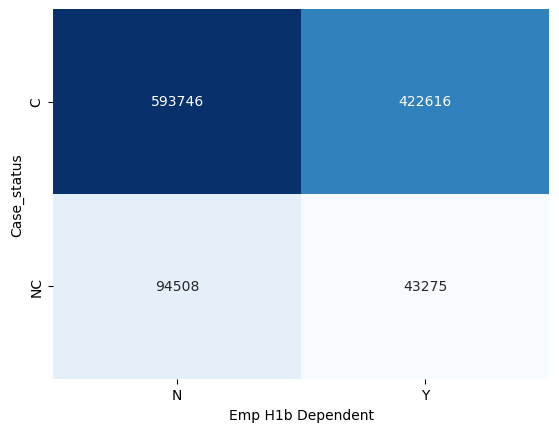

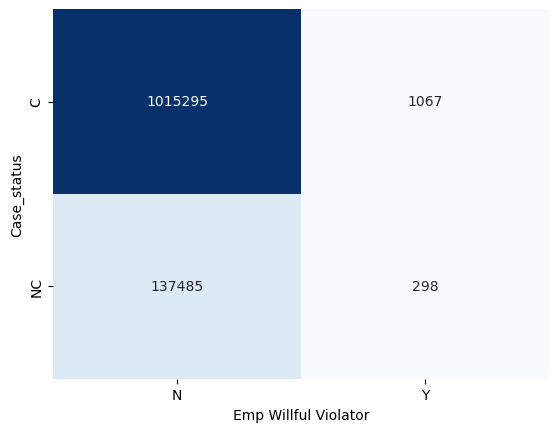

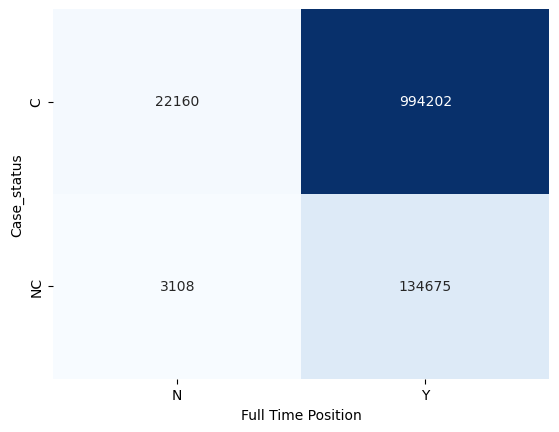

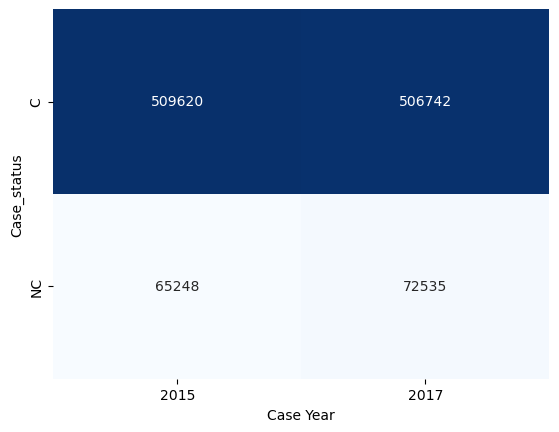

In [11]:
# Create confusion  matrix for binary features
def makeconfmatrix(feature):
    """
    creates a confusion matrix for binary features that plots Case Status and the feature parameter
    """
    le = LabelEncoder()
    a = le.fit_transform(data_clean['case_status'])
    b = le.fit_transform(data_clean[feature])  
    conf_matrix = confusion_matrix(a,b)

    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
                xticklabels=["N", "Y"], yticklabels=["C", "NC"])
    
    words = feature.split("_")

    # capitalize each word and join them back into a string
    new_string = " ".join([word.capitalize() for word in words])
    plt.xlabel(new_string)
    plt.ylabel("Case_status")
    plt.show()

makeconfmatrix('emp_h1b_dependent')
makeconfmatrix('emp_willful_violator')
makeconfmatrix('full_time_position')


#now, make a heatmap for the Case Year feature
le = LabelEncoder()
a = le.fit_transform(data_clean['case_status'])
b = le.fit_transform(data_clean['case_year'])  
conf_matrix = confusion_matrix(a,b)

sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=["2015", "2017"], yticklabels=["C", "NC"])

plt.xlabel("Case Year")
plt.ylabel("Case_status")
plt.show()

The most notable correlation was between willful violator and case status. If an employer was not a willful violator, their chances of having their applications be confirmed were much higher.

This code performs some data preprocessing and aggregation on a cleaned dataset (data_clean) by first setting two multi-level indices on the dataframe based on 'emp_name' and 'case_status' or 'emp_h1b_dependent'. It then uses these indices to create two new dataframes, case_by_emp and h1bdep_by_emp, which group and count the number of cases for each employer by case status and by H1B dependence, respectively.

In [12]:
emp_case_idx = data_clean.set_index(['emp_name','case_status'])
emp_h1bdep_idx = data_clean.set_index(['emp_name','emp_h1b_dependent'])

case_by_emp = (
            emp_case_idx
            .groupby(['emp_name','case_status'])
            .count()['case_year']
            .unstack()
            .fillna(0)
)

h1bdep_by_emp = (
            emp_case_idx
            .groupby(['emp_name','emp_h1b_dependent'])
            .count()['case_year']
            .unstack()
            .fillna(0)
)

case_by_emp_tots = case_by_emp.sum(axis=1)
emp_case_idx = data_clean.set_index(['emp_name','case_status'])
emp_h1bdep_idx = data_clean.set_index(['emp_name','emp_h1b_dependent'])

case_by_emp = (
            emp_case_idx
            .groupby(['emp_name','case_status'])
            .count()['case_year']
            .unstack()
            .fillna(0)
)

h1bdep_by_emp = (
            emp_case_idx
            .groupby(['emp_name','emp_h1b_dependent'])
            .count()['case_year']
            .unstack()
            .fillna(0)
)

case_by_emp_tots = case_by_emp.sum(axis=1)

This function calculates the percentage of each case status (certified or denied) within each category of the specified feature. This plot can help identify any imbalances in the distribution of case statuses across different categories of the feature. For example, if a certain feature category has a much higher percentage of denied cases compared to the overall percentage of denied cases, it may indicate that this category is a risk factor for case denial and vice versa for certified cases. 

  emp_h1b_dependent case_status    percent
0                 N           C  86.268442
1                 N          NC  13.731558
2                 Y           C  90.711347
3                 Y          NC   9.288653


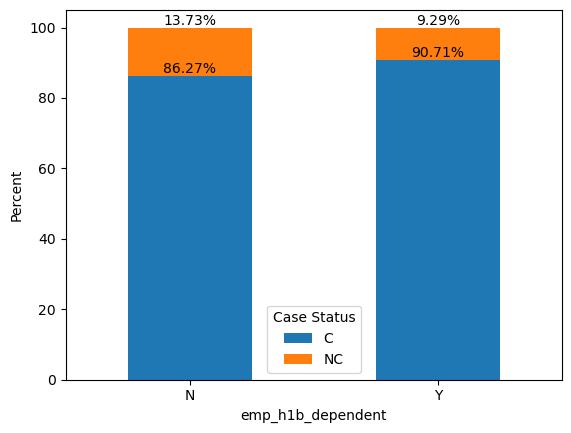

  emp_willful_violator case_status    percent
0                    N           C  88.073613
1                    N          NC  11.926387
2                    Y           C  78.168498
3                    Y          NC  21.831502


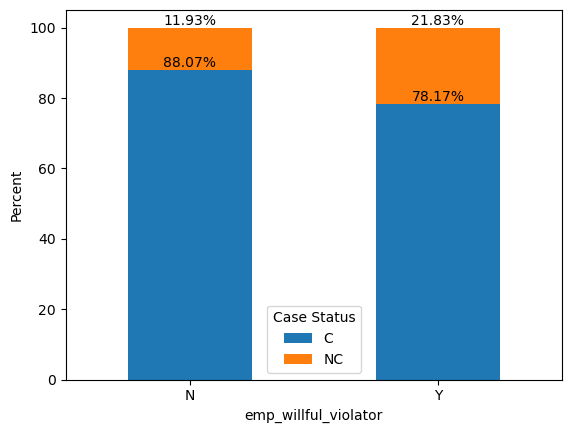

  full_time_position case_status    percent
0                  N           C  87.699858
1                  N          NC  12.300142
2                  Y           C  88.070002
3                  Y          NC  11.929998


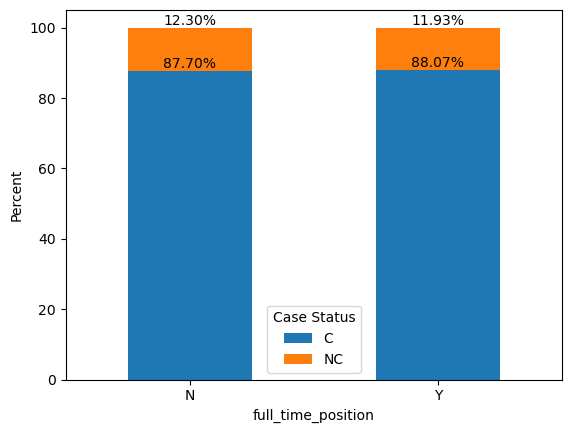

   case_year case_status    percent
0       2015           C  88.649916
1       2015          NC  11.350084
2       2017           C  87.478357
3       2017          NC  12.521643


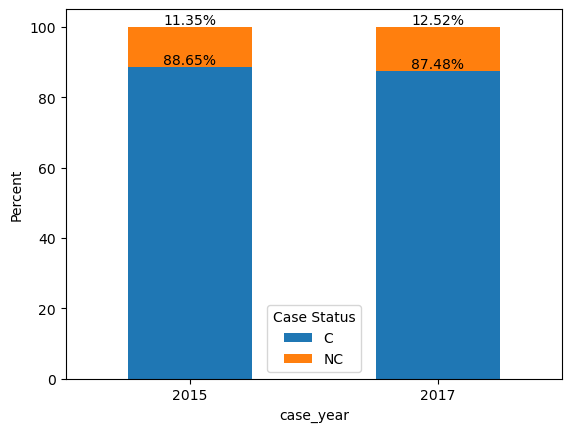

In [13]:
import matplotlib.ticker as ticker


def makebargraph(feature):
   """
   makes a bar graph for binary and categorical features
   """
   counts = data_clean.groupby(feature)['case_status'].value_counts(normalize=True)
   counts = counts.mul(100).rename('percent').reset_index()
   print(counts)
   counts = counts.pivot(index=feature, columns='case_status', values='percent')


   ax = counts.plot.bar(stacked=True, rot=0)
   ax.set_ylabel('Percent')
   ax.legend(title='Case Status')


   # Add percentage values to each bar
   for container in ax.containers:
       ax.bar_label(container, label_type='edge', labels=[f'{val:.2f}%' for val in container.datavalues])


   plt.show()




makebargraph('emp_h1b_dependent')
makebargraph('emp_willful_violator')
makebargraph('full_time_position')
makebargraph('case_year') 

The histogram of the prevailing wage can be significant because it provides an overview of the distribution of the wages in the dataset. It helps to understand the range of wages that the H1B visa applicants are earning in the United States. 

Text(0, 0.5, 'Frequency')

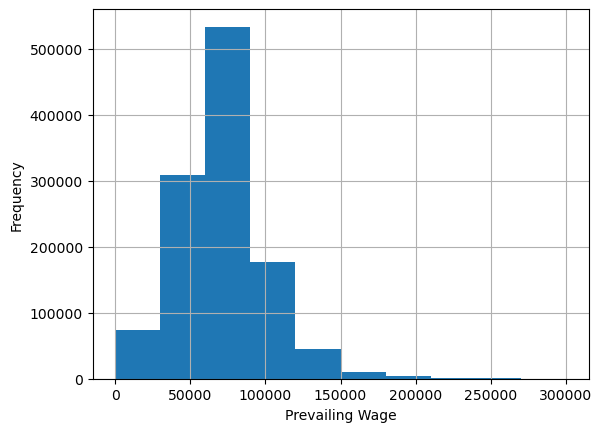

In [14]:
#make histogram for prevailing wage

data_clean['prevailing_wage'].hist(bins = 10, range = (0, 300000))
plt.xlabel('Prevailing Wage')
plt.ylabel('Frequency')

#### Feature Engineering

We crafted 5 new features from those that were in our dataset that we felt were relevant. We believe these new features could improve the predictive performance of more sophisticated models. These 5 new features are:
- Type of Occupation/SOC Field: this will give a broad occupational category based on the Dept. of Labor's SOC system
- Application Duration: the period of time between the application being submitted and the decision being made
- Location: general location (ex: SouthWest) that the employer is located in
- Yearly Prevailing Wage: expected annual salary for the job position being applied for
- Job Demand: Counts number of applications submitted to each employer to test if there is demand for these poisitions offered by employers


In [15]:
#SOC field

data_clean['soc_field'] = data_clean['soc_code'].str[:2]
data_clean['soc_code'].unique()
#cleaning up the soc_field column
#both of the occupations represented by these letters fall under 15, 
data_clean['soc_field'] = data_clean['soc_field'].replace(['CO', 'SO'], '15') 

#the occupations represented by these letters fall under 17
data_clean['soc_field'] = data_clean['soc_field'].replace(['EL', 'EN', 'ME'], '17')
data_clean['soc_field'] = data_clean['soc_field'].replace('1-', '31') 

In [26]:
#casting data_clean to data_final to preserve the original clean dataset. data_final will contain our generated features
data_final = data_clean
fp = Path('data/data_final.csv')
data_final.to_csv(fp)


In [42]:
data_final.columns

Index(['case_year', 'case_status', 'case_submitted', 'decision_date',
       'emp_name', 'emp_city', 'emp_state', 'emp_zip', 'job_title', 'soc_code',
       'full_time_position', 'prevailing_wage', 'pw_unit', 'wage_from',
       'wage_unit', 'work_city', 'work_state', 'emp_h1b_dependent',
       'emp_willful_violator', 'soc_field', 'pw_yearly', 'wage_from_yearly',
       'application_duration', 'location'],
      dtype='object')

In [17]:
#convert prevailing wage to yearly wage based off the pw_unit column (prevailing wage unit)
conversion_factors = {'Y':1,'H':2080,'M':12,'W':52,'BW':26}
data_final['pw_yearly'] = (
        data_final.apply(lambda row: row['prevailing_wage'] * conversion_factors[row['pw_unit']], axis=1)
                           )

data_final['wage_from_yearly'] = (
    data_final.apply(lambda row: row['wage_from'] 
    * conversion_factors[row['wage_unit']], axis=1)
                                  )

In [18]:
#exploration of any discrepancy between yearly prevailing wage and yearly wage; this was not used in the final dataset
wage_diff = (
    (
    data_final['pw_yearly']-data_final['wage_from_yearly']
     )/data_final['wage_from_yearly']
    )*1.0

wage_diff.describe()

count    1.154144e+06
mean              inf
std               NaN
min     -1.000000e+00
25%     -1.549286e-01
50%     -5.290000e-02
75%      0.000000e+00
max               inf
dtype: float64

In [19]:
#Application Duration
data_final['application_duration'] = (data_clean['decision_date'] - data_clean['case_submitted']).dt.days


In [20]:
#Location
def get_location_from_zip(zip_code):
    """
    uses zip_code parameter to find the broader geographical region the employer is in
    """
    if not zip_code.isnumeric() or len(zip_code) < 5:
        return "Unknown"
    region_code = int(zip_code[0])
    if region_code == 0 or region_code == 1:
        return "Northeast"
    elif region_code == 7 or region_code == 3 or region_code == 2:
        return "South"
    elif region_code == 4 or region_code == 5 or region_code == 6:
        return "Midwest"
    elif region_code == 8 or region_code == 9:
        return "West"
    else:
        return "Unknown"

data_final['location'] = data_clean['emp_zip'].apply(get_location_from_zip)



In [21]:
job_demand = data_clean.groupby('emp_name').size().reset_index(name='job_demand')
data_final = pd.merge(data, job_demand, on='emp_name', how='left')

Now that we have constructed our 5 new features, we got rid of redundant features to reduce the dimensional load on future training.

In [22]:
drop_cols = [
     "emp_zip",
    "pw_unit", 
    "wage_unit",
    "work_city",
  "work_state",
  "case_submitted",
  "decision_date"
]

data_final = data_final.drop(drop_cols, axis=1) 


data_final = data_final.replace('Y',1).replace('N',0)
data_final.head()

,case_year,case_status,emp_name,emp_city,emp_state,job_title,soc_code,full_time_position,prevailing_wage,wage_from,emp_h1b_dependent,emp_willful_violator,job_demand
0,2017,C,"LAKELANDS NEPHROLOGY, PA",GREENWOOD,SC,NEPHROLOGIST,29-1063,1.0,187200.0,190000.00,0.0,0.0,2.0
1,2017,C,UNIVERSITY OF IDAHO,MOSCOW,ID,POST DOCTORAL FELLOW,19-1013,1.0,39957.0,47507.00,0.0,0.0,52.0
2,2017,C,"XPO SUPPLY CHAIN, INC.",HIGH POINT,NC,OPERATION ANALYST,15-2031,1.0,59966.0,65000.00,0.0,0.0,37.0
3,2017,C,"C AND S WHOLESALE GROCERS, INC.",KEENE,NH,SR. INDUSTRIAL ENGINEER,17-2112,1.0,78832.0,86988.15,0.0,0.0,28.0
4,2017,C,SANFORD CLINIC,SIOUX FALLS,SD,HEMATOLOGIST/ONCOLOGIST,29-1069,1.0,169645.0,450000.00,0.0,0.0,79.0


#### Baseline Models

We have two baseline models that we aim to surpass in predictive power in terms of our selected error metrics. 

The first model is a simple decision stump classifier based on our findings from the confusion matrix between Willful Violator and Case Status. As per the findings, Willful Violator is heavily correlated with Case Status. This simple decision stump classifier is based on the assumption that being a willful violator would result in a rejected application.

The second model is a Naive Bayes Classifier selected as a lower bound for multivariate machine learning performance. Primarily selected for its simplicity and training speed, this model also serves as a good baseline to compare more complex models to. 

Ideally, we surpass our first baselines model in all of our evaluation metrics but we expect to outperform the second baseline model.

In [23]:
def simple_decision_stump_classifier(row):
    if row['emp_willful_violator']=='N':
        return 'C'
    else:
        return 'NC'
    
dec_stump_preds = data_clean.apply(simple_decision_stump_classifier, axis=1)
true = data_clean['case_status']

In [25]:
print("\nSimple Decision Stump Accuracy: "+accuracy_score(true, dec_stump_preds))
print("\nSimple Decision Stump F1 Score: "+f1_score(true, dec_stump_preds))

TypeError: can only concatenate str (not "numpy.float64") to str

In [ ]:
#here, we calculate the accuracy and f1_score of the decision stump classifier prediction

TP = np.count_nonzero([(true=="C") & (dec_stump_preds=="C")])
FP = np.count_nonzero([(true=="NC") & (dec_stump_preds=="C")])
TN = np.count_nonzero([(true=="NC") & (dec_stump_preds=="NC")])
FN = np.count_nonzero([(true=="C") & (dec_stump_preds=="NC")])

# calculate accuracy
accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy:", accuracy)

# calculate precision
precision = TP / (TP + FP)

# calculate recall
recall = TP / (TP + FN)

# calculate f1 score
f1_score = 2 * precision * recall / (precision + recall)
print("F1 Score:", f1_score)

In [ ]:
#repeatable random sample of 20000 to avoid memory and time constraints for the checkpoint, if memory permitting, will use larger sample in future
df = data_final.sample(n=20000, random_state=42)

X=df[[c for c in df.columns if c!='case_status']]

y=df['case_status']

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ss_col = [
    'wage_from_yearly',
    'pw_yearly',
    'application_duration'
]

bin_col = [
    "emp_h1b_dependent",
    "emp_willful_violator",
    "full_time_position"
]

label_col = [
    "case_year",
]

oneh_col = [
    "soc_field",
    "emp_name",
    "location",
]

nb = GaussianNB()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ss_col),
        ('bin', Binarizer(), bin_col),
        ('label', OrdinalEncoder(), label_col),
        ('oneh', OneHotEncoder(handle_unknown='ignore'), oneh_col)
    ]
)

preprocessor.fit(X_train)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', nb)
])

# Fit the pipeline on the training data
X_train_processed = pipeline.named_steps['preprocessor'].transform(X_train)
nb.fit(X_train_processed.toarray(), y_train)

# Evaluate the pipeline on the testing data
X_test_processed = pipeline.named_steps['preprocessor'].transform(X_test)
accuracy = nb.score(X_test_processed.toarray(), y_test)
print(f"Accuracy: {accuracy}")



# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



In [100]:
import numpy as np
import pandas as pd
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [101]:
#skipping preprocessing steps with saved csv
file_names = ['final_data_p1.csv', 'final_data_p2.csv']

# Initialize an empty list to store the data frames
dfs = []

# Loop over the file names, read each file into a DataFrame, and append to the list
for file in file_names:
    df = pd.read_csv("data/"+file, low_memory=False)
    dfs.append(df)

# Concatenate the DataFrames in the list into a single DataFrame
data_final2 = pd.concat(dfs, axis=0)

# Reset the index of the combined DataFrame
data_final_XG = data_final2.reset_index(drop=True)
data_final_XG.shape

(1154145, 18)

In [102]:
bool_dict = {'C':True,'NC':False}
data_final_XG['case_status'] = data_final_XG['case_status'].map(bool_dict)


In [103]:
def convert_to_category(col):
    if col.dtypes == 'object':
        return col.astype('category')
    else:
        return col
data_final_XG = data_final_XG.apply(convert_to_category)
data_final_XG.dtypes

case_year                  int64
case_status                 bool
emp_name                category
emp_city                category
emp_state               category
job_title               category
soc_code                category
full_time_position         int64
prevailing_wage          float64
wage_from                float64
emp_h1b_dependent          int64
emp_willful_violator       int64
soc_field                  int64
pw_yearly                float64
wage_from_yearly         float64
application_duration       int64
location                category
job_demand                 int64
dtype: object

In [104]:
X=data_final_XG[[c for c in df.columns if c!='case_status']]

y=data_final_XG['case_status']

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [105]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))
def report_application_status(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



In [106]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve,roc_auc_score
import matplotlib.pyplot as plt

def evaluate_classification(true, pred, title):
   accuracy = accuracy_score(true, pred)
   f1 = f1_score(true, pred, pos_label=True)
   roc_auc = roc_auc_score(true==True, pred==True)
   fpr, tpr, thresholds = roc_curve(true==True, pred==True)
   plt.plot(fpr, tpr)
   plt.plot([0, 1], [0, 1])
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title(title +' ROC Curve')
   plt.show()
   return {'accuracy': accuracy, 'f1': f1, 'roc score': roc_auc}


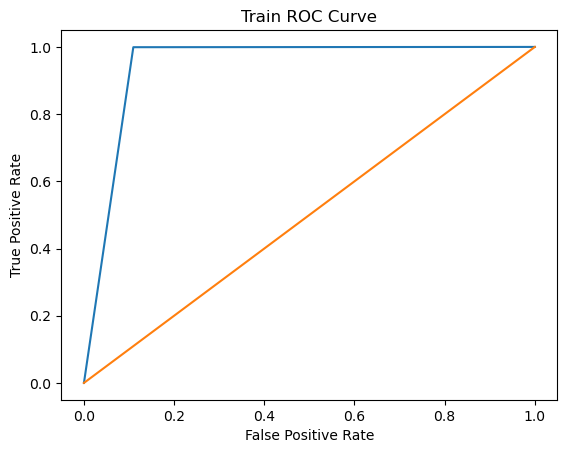

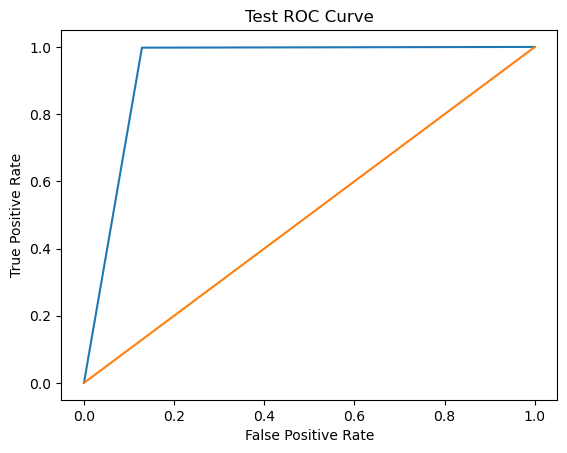

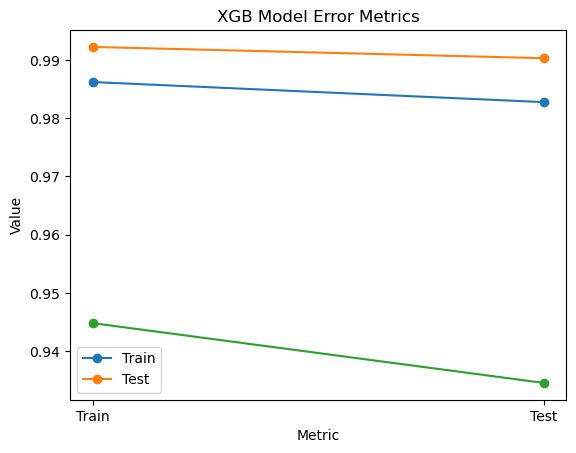

In [109]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',tree_method = 'hist',enable_categorical = True,random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

XGB_e_metrics_train = evaluate_classification(y_train,y_pred_train,'Train')
XGB_e_metrics_test = evaluate_classification(y_test,y_pred_test,'Test')

XGB_errors = pd.DataFrame([XGB_e_metrics_train], index=["Train"])
XGB_errors.loc["Test"] = XGB_e_metrics_test

plt.plot(XGB_errors,marker='o')
plt.legend(XGB_errors.index)

plt.title("XGB Model Error Metrics")
plt.xlabel("Metric")
plt.ylabel("Value")

plt.show()


In [110]:
XGB_errors

,accuracy,f1,roc score
Train,0.986193,0.992215,0.944841
Test,0.982749,0.990282,0.934591


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

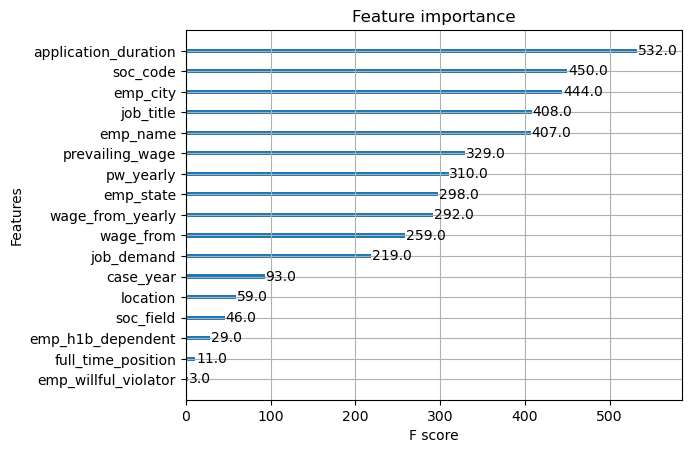

In [108]:
xgb.plot_importance(xgb_model)


# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

There are several ethics and privacy concerns with the dataset we have chosen regarding H1-B Non Immigrant Labour Visa. The dataset that we have is anonymous, however, with the features described, employees could be re-identified, as the dataset contains information regarding the city, state, and zip code of both the employer and employee. However, to address this, we will refrain from using information of the employee in our project. The dataset also avoids proxy discrimination, as we are not using features such as race, origin, sex, and age, rather using attributes from the company. As far as bias, since we are mainly going to be using columns regarding the employer and the case status, and disregarding columns related to the employee. As we are reducing the number of columns used, we could be missing some potential variables that could lead to biased predictions in our results regarding the approval of visas. To address this we will use evaluation metrics that mitigate bias. In terms of the impact of our work, it's important to consider the potential consequences of the decisions that are made based on your analysis. For example, if our analysis suggests that certain employers are more likely to receive H1-B visas than others, this could have a significant impact on the job market and on the lives of the people involved. It's therefore important to take steps to mitigate any potential biases in our analysis, and to ensure that your work is fair, accurate, and ethical.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.


# Footnotes
<a name="mpinote"></a>1.[^](#mpinote): Migration Policy Institute. (2022). H-1B Temporary Skilled Worker Program. Retrieved February 22, 2023, from https://www.migrationpolicy.org/article/h-1b-temporary-skilled-worker-program.<br> 
<a name="iqbalnote"></a>2.[^](#iqbalnote): M. Tariq Iqbal, M. Irfan Ullah, M. Ahsan Nazir, "A Hybrid Algorithm for Optimal Placement and Sizing of Distributed Generation in a Distribution System", IEEE Access, vol. 7, pp. 174089-174102, 2019. doi: 10.1109/ACCESS.2019.2953292. https://ieeexplore.ieee.org/abstract/document/8933628<br>
<a name="rananote"></a>3.[^](#rananote): Rana, P., Kumar, S., & Yadav, S. (2019). An allotment of H1B work visa in USA using machine learning. International Journal of Recent Technology and Engineering, 8(3S), 539-545. Available from: https://www.researchgate.net/profile/Prashant-Rana-4/publication/328488339_An_allotment_of_H1B_work_visa_in_USA_using_machine_learning/links/5d70f092a6fdcc9961afad48/An-allotment-of-H1B-work-visa-in-USA-using-machine-learning.pdf.<br>
<a name="paulnote"></a>4.[^](#paulnote): Paul, U., & Langlois, A. (2022). Understanding the Determinants of H-1B Decisions: A Machine Learning Approach. Northeastern University, College of Social Sciences and Humanities. Retrieved February 22, 2023, from https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4143882<br>

